# III - Gradient-based design optimization with control points

- **Parametric optimization** is not incompatible with gradient optimization. 
- The derivatives can be evaluated using **finite differences**, but this requires at least as many additional function evaluations as the number of parameters $N$. With many parameters (say $N>10$), using finite difference becomes **really costly**, especially when evaluating the function requires solving finite element problems.
- Thanks to mathematical tools such as shape derivative and adjoint method, the derivatives can be evaluated efficiently with only $1$ additional resolution of a linear finite element problem per function to derivate (so-called adjoint).

In [2]:
from shapeOptInductor import gen_meshN, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

First, we set up the number of control points (with adjoint method, computation time is almost independant of the number of parameters).

In [3]:
##############################################
NControlPoints = 30 # can be changed
##############################################
print(f"{NControlPoints = }")

NControlPoints = 30


___________________________
## 1 - Geometry and meshing

Then, we define the inductor geometry and generate the mesh.

In [4]:
# Geometric parameters
lz = 1e-2               # z-thickness of the inductor  
s = 4                   # symmetry factor (model 1/4th of the total space)

# Mesh generation
airgap = 4.11e-3 * np.ones(NControlPoints)              # Array of y-coordinates of control points along the airgap
maxh = 2e-3                                             # Maximum size of mesh element
mesh, p1, p2 = gen_meshN(airgap, maxh)                  # Generate the mesh and return the coordinates of control points on the first and second leg
xAirgaps = [p[0] for p in p1] + [p[0] for p in p2]      # Extract the x-coordinates of the control points

# Define the characteristics functions
XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})
materials_regions = 1 * XiAir + 2 * XiCoil + 3 * XiCore

# Draw the geometry and mesh
Draw(materials_regions, mesh, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

___________________________
## 2 - State problem (time-harmonic magnetics)

### 2.a - Parameters definition

We describe the magnetic permeabilities and the source currents.

In [5]:
# Electric current (assumed sinusoidal)
f = 5e4                                                         # Working frequency (Hz)
omega = 2 * np.pi * f                                           # rad/s
nb_turn = 200                                                   # Number of turn in the coil (no unit)
I = 2                                                           # Amplitude of the source current (A)
j = nb_turn / 2 * I / (ngs.Integrate(XiCoil, mesh)) * XiCoil    # Amplitude of the source current density  (A/m²)

# Magnetic permeabilities
mu0 = 4e-7 * np.pi                                              # Void permeability (H/m)
mur = 1000                                                      # Relative permeability of iron (no unit)
mu_iron = mur * mu0                                             # Iron permeability (H/m)
delta = 0.1                                                     # Loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0                             # Complex permeability of the coil

### 2.b - Definition of the time-harmonic magnetics problem

Then we can write the weak formulation and solve the following problem :
$$\text{Find } \underline{a_h} \in H := \{\underline{a} \in H^1(\Omega) |\, \underline{a} = 0 \text{ on } \Gamma_D\} \quad \text{ s.t. } \quad
    \forall \underline{v} \in H, \int_\Omega \underline{\nu_h} (\nabla \underline{a_h}) \cdot (\nabla \underline{v})^* \,\mathrm{d}x = \int_{\Omega_{c, h}} j \underline{v}^* \, \mathrm{d}x. $$

In [6]:
def magWeakFormComplex(ah : ngs.FESpace.TrialFunction, 
                       v  : ngs.FESpace.TestFunction
                       ) -> tuple[ngs.BilinearForm, ngs.LinearForm]:
    """Return the sybolic weak form of the magnetic problem, 
    i.e, bilinear and linear forms (not assembled yet)."""

    # Bilinear form (transmission)
    bf =  1 / mu_iron * ngs.grad(ah) * ngs.grad(v) * ngs.dx("core")
    bf += 1 / mu_coil * ngs.grad(ah) * ngs.grad(v) * ngs.dx("coil")
    bf += 1 / mu0 * ngs.grad(ah) * ngs.grad(v) * ngs.dx("air")

    # Linear form (source)
    lf = j * v * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh : ngs.Mesh
                      ) -> tuple[ngs.GridFunction, ngs.la.BaseMatrix]:
    """ Solve the time-harmonic magnetics problem """

    # Definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|domainVert", complex=True)
    a, v = fes.TnT()

    # Definition of weak form
    bf, f = magWeakFormComplex(a, v)

    # Assembly
    K = ngs.BilinearForm(bf).Assemble()
    F = ngs.LinearForm(f).Assemble()

    # Solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs())
    gf.vec.data = Kinv * F.vec

    return gf, Kinv  # returning Kinv speed up adjoint calculation

# Example :
state, Kinv = solveStateComplex(mesh)
Draw(state.real, mesh, radius=0.02, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 2.c - Definition of the post-processed quantities

We define the losses and inductance 
$$
\begin{array}{lcl}
P(\underline{a}) &=& \displaystyle  s l_z  \pi f \int_{\Omega_c} \text{Im} \left( \frac{1}{\underline{\mu_c}} \right ) |\nabla \underline{a}|^2 \;\mathrm{d}x,\\
L(\underline{a}) &=& \displaystyle \frac{s l_z}{I^2} \int_\Omega \text{Re} \left( \underline{\nu} \right) |\nabla \underline{a}|^2 \;\mathrm{d}x,\\
\end{array}$$

with their directional derivatives.

In [7]:
def L(state : ngs.GridFunction, 
      mesh : ngs.Mesh
      ) -> float:
    """ Compute inductance from the time-harmonic solution """
    nu = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (I**2) * ngs.Integrate(nu.real * ngs.Norm(ngs.grad(state)) ** 2, mesh)


def ddL(state : ngs.GridFunction, 
        v : ngs.FESpace.TestFunction
        ) -> ngs.comp.SumOfIntegrals:
    """ Compute directional derivative of the inductance from the time-harmonic solution """
    nu = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * s * lz / (I**2) * ngs.InnerProduct(nu.real * ngs.grad(state), ngs.grad(v)) * ngs.dx


def P(state : ngs.GridFunction,
      mesh : ngs.Mesh
      ) -> float:
    """ Compute AC losses in the conductor from the time-harmonic solution """
    nu = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(nu.imag * ngs.Norm(ngs.grad(state)) ** 2, mesh)


def ddP(state : ngs.GridFunction, 
        v : ngs.FESpace.TestFunction
        ) -> ngs.comp.SumOfIntegrals:
    """ Compute directional derivative of AC losses in the conductor from the time-harmonic solution """
    nu = XiCoil / mu_coil
    return 2 * s * np.pi * f * lz * ngs.InnerProduct(nu.imag * ngs.grad(state), ngs.grad(v)) * ngs.dx

# Example :
print(f"Inductance : {L(state, mesh) *1000:.3} mH")
print(f"Losses : {P(state, mesh):.3} W")

Inductance : 1.0 mH
Losses : 13.2 W


___________________________
## 3 - Adjoint problem

The adjoint method is an efficient way to compute derivatives of PDE-constrained problem; it requires solving one linear auxiliary problem per function $f$ to derivate that reads

$$ \text{Find } \underline{p}_f \in H \quad \text{ s.t. } \quad
    \forall \underline{v} \in H,  \quad \int_\Omega \nabla \underline{p}_f \cdot \underline{\nu}^* \nabla \underline{v} \; \mathrm{d}x = \int f'(\underline{a})(\underline{v})\; \mathrm{d}x, $$

with $f'$ the directional derivative of $f$, such that $F(\underline{a}) = \int_\Omega f(\underline{a}) \; \mathrm{d}x$.

In [8]:
def solveAdjoint(state : ngs.GridFunction,      
                 df : ngs.comp.SumOfIntegrals,
                 Kinv : ngs.la.BaseMatrix
                 ) -> ngs.GridFunction:
    """Solve the adjoint equation for a given directional derivative (right-hand side)"""

    fes = state.space
    v = fes.TestFunction()

    # Assemble the right-hand side
    f = ngs.LinearForm(-1. * df(state, v)).Assemble()
    
    # Solve using the adjoint (transconjugate) of provided FEM matrix
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec

    return gf

# Example :
adjoint_P = solveAdjoint(state, ddP, Kinv)
Draw(adjoint_P.real, mesh, radius = 0.02, settings = {"Objects" : { "Wireframe" : False }})

adjoint_L = solveAdjoint(state, ddL, Kinv)
Draw(adjoint_L.real, mesh, radius = 0.02, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

___________________________
## 4 - Continuous and discretized shape derivatives

### 4.a - Continuous expressions

The shape derivative of the losses is a linear form obtained by Céa's method that reads
$$\mathrm{d} P(\Omega)(\phi) = \text{Re}\left( s l_z \pi f \int_{\Omega_c} \text{Im}\left(\frac{1}{\underline{\mu_c}}\right) A_\phi \nabla \underline a \cdot (\nabla \underline a)^* \; \mathrm{d} x + \int_\Omega \underline{\nu} A_\phi \nabla \underline{a} \cdot \nabla \underline p_P^* \mathrm{d} x - \int_{\Omega_c} j\, \text{div} \phi\, \underline p_P^*  \mathrm{d} x \right)  $$

with $\phi\in W^{1, \infty}(\mathbb{R}^2,\mathbb{R}^2)$ and $A_\phi = \text{div} \phi \, I_2 - \nabla \phi - \nabla \phi^\top$.

In [9]:
def sdP(state : ngs.GridFunction,
        adjoint_P : ngs.GridFunction
        ) -> ngs.LinearForm :
    """ Compute the shape derivative (linear form) of the AC losses inside the coil """

    # Finite element spaces
    mesh = state.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    phi = FEScomplex.TestFunction()

    # Shorthands
    nu = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_losses = s * np.pi * f * lz * (1 / mu_coil).imag
    dA = ngs.div(phi) * Id - ngs.grad(phi) - ngs.grad(phi).trans

    # Shape derivative
    shape_derivative_cplx = ngs.LinearForm(FEScomplex)
    shape_derivative_cplx += coeff_losses * ngs.InnerProduct(dA * ngs.grad(state), ngs.grad(state)) * ngs.dx("coil")
    shape_derivative_cplx += -j * XiCoil * ngs.div(phi) * adjoint_P * ngs.dx
    shape_derivative_cplx += ngs.InnerProduct(nu * dA * ngs.grad(state), ngs.grad(adjoint_P)) * ngs.dx
    shape_derivative_cplx.Assemble()

    # Take the real part
    shape_derivative = ngs.LinearForm(FESReal)
    shape_derivative.vec.FV().NumPy()[:] = np.real(shape_derivative_cplx.vec.FV().NumPy()[:])

    return shape_derivative

Similarly, computing the shape derivative of the inductance leads to

$$ 
 \mathrm{d}  L(\Omega)(\phi) =  \text{Re}\left( \frac{s l_z}{I^2} \int_\Omega \underline{\nu} A_\phi \nabla \underline{a} \cdot (\nabla \underline a)^* \; \mathrm{d} x  + \int_\Omega \underline{\nu} A_\phi \nabla \underline{a} \cdot \nabla \underline p_L^* \mathrm{d} x - \int_{\Omega_c} j\,\text{div} \phi\, \underline p_L^*  \mathrm{d} x \right) 
$$

In [10]:
def sdL(state : ngs.GridFunction,
        adjoint_L : ngs.GridFunction
        ) -> ngs.LinearForm :
    """ Compute the shape derivative (linear form) for the inductance"""

    # Finite element spaces
    mesh = state.space.mesh
    FEScomplex = ngs.H1(mesh, complex = True)**2 #ngs.VectorH1(mesh, complex=True)
    FESReal = ngs.H1(mesh)**2 # ngs.VectorH1(mesh)
    phi = FEScomplex.TestFunction()

    # Shorthands
    nu = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_induc = s * lz / (I**2) * nu.real
    dA = ngs.div(phi) * Id - ngs.grad(phi) - ngs.grad(phi).trans

    # Shape derivative 
    shape_derivative_cplx = ngs.LinearForm(FEScomplex)
    shape_derivative_cplx += coeff_induc * ngs.InnerProduct(dA * ngs.grad(state), ngs.grad(state)) * ngs.dx
    shape_derivative_cplx += -j * ngs.div(phi) * adjoint_L * ngs.dx
    shape_derivative_cplx += ngs.InnerProduct(nu * dA * ngs.grad(state), ngs.grad(adjoint_L)) * ngs.dx
    shape_derivative_cplx.Assemble()
    shape_derivative = ngs.LinearForm(FESReal)
    shape_derivative.vec.FV().NumPy()[:] = np.real(shape_derivative_cplx.vec.FV().NumPy()[:])

    return shape_derivative

### 4.b - Discrete shape derivatives
- The shape derivative is a **linear form**, from which we can extract a **descent direction**.
- At the discrete level, one possibility is to extract directly the **nodal coefficients** from the assembled linear form, which is a vector.
    - It represents the derivative of the losses with respect to the **coordinates of the mesh nodes**. In a sense, it represents the **shape gradient** of the discretized model.
    - It takes the form of a nodal vector field, indicating in which direction one should move every node of the mesh to increase $f$ maximally.
- We can therefore plot it, as below. It is almost 0 everywhere (should be exactly 0 up to the discretization errors), except on the **edges** of the geometry. 
    - Indeed, displacing a node at an interface modify the material distribution, which impacts the value of the scalar function, while moving a point from the inside doesn't change the geometry.
- The **correctness** of the point-wise values of the discretized shape derivative can therefore be checked by **finite difference**, which is the purpose of the last section.

In [11]:
# Nodal identification of the shape derivative of the losses:
sdP_linear_form = sdP(state, adjoint_P)
discrete_shape_gradient_P = ngs.GridFunction(sdP_linear_form.space)
discrete_shape_gradient_P.vec.data = sdP_linear_form.vec
Draw(discrete_shape_gradient_P, mesh, radius = 0.02, vectors={"grid_size":100}, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [12]:
# Nodal identification of the shape derivative of the inductance:
sdL_linear_form = sdL(state, adjoint_L)
discrete_shape_gradient_L = ngs.GridFunction(sdL_linear_form.space)
discrete_shape_gradient_L.vec.data = sdL_linear_form.vec
Draw(discrete_shape_gradient_L, mesh, radius = 0.02, vectors={"grid_size":100}, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 4.c - Sensitivities with respect to the control points

The sensitivities with respect to the $y$-coordinate of the control points (i.e., the first order derivatives of the quantity of interest) are simply obtained by taking the scalar product of the discretized shape derivative with a displacement field induced by the displacement of the control points.

To obtain the true derivative, the displacement of the control point should be unitary. In the literature, this displacement can also be called a "velocity" because it can be used as a descent direction, transporting the geometry through a pseudo-time that are iterations of the algorithm. It is also possible (rather recommended) to use other descent direction using a regularization.

In [13]:
from shapeOptInductor import referenceVelocity

def sensitivities_y_control_points(state : ngs.GridFunction,
               adjoint : ngs.GridFunction,
               shape_derivative : callable,
               x_airgap : list[float]) -> list[float]:
    """ Compute the sensitivities of a function with respect to the y-value of the control points """

    velocityFields = referenceVelocity(state.space.mesh, x_airgap)
    sd_linearform = shape_derivative(state, adjoint)
    sd_discretized = ngs.GridFunction(ngs.VectorH1(state.space.mesh))
    sd_discretized.vec.FV().NumPy()[:] = np.real(sd_linearform.vec.FV().NumPy()[:])
    sensitivities = [ ngs.InnerProduct(sd_discretized.vec, refVelocity.vec) for refVelocity in velocityFields]
    return sensitivities

# Example:
sensitivities_P = sensitivities_y_control_points(state, adjoint_P, sdP, xAirgaps)
sensitivities_L = sensitivities_y_control_points(state, adjoint_L, sdL, xAirgaps)

print("dL/dy = [ " + ', '.join(f"{k:.3e}" for k in sensitivities_P) + " ]")
print("dP/dy = [ " + ', '.join(f"{k:.3e}" for k in sensitivities_L) + " ]")

dL/dy = [ 4.567e+01, 9.131e+01, 9.119e+01, 9.096e+01, 9.052e+01, 8.974e+01, 8.838e+01, 8.595e+01, 8.174e+01, 7.411e+01, 5.939e+01, 2.962e+01, -4.272e+01, -4.868e+02, -2.064e+03, -1.117e+03, -3.902e+02, -1.386e+02, -9.400e+01, -7.562e+01, -6.665e+01, -6.192e+01, -5.952e+01, -5.852e+01, -5.859e+01, -5.985e+01, -6.302e+01, -7.075e+01, -1.059e+02, -1.440e+02 ]
dP/dy = [ -7.634e-03, -1.527e-02, -1.527e-02, -1.528e-02, -1.530e-02, -1.532e-02, -1.537e-02, -1.545e-02, -1.559e-02, -1.584e-02, -1.632e-02, -1.725e-02, -1.936e-02, -2.903e-02, -3.780e-02, -1.611e-02, -1.246e-02, -8.256e-03, -7.344e-03, -6.953e-03, -6.764e-03, -6.674e-03, -6.648e-03, -6.675e-03, -6.767e-03, -6.961e-03, -7.360e-03, -8.282e-03, -1.241e-02, -1.689e-02 ]


In [14]:
np.dot([1,2,3],[3,2,1.])

np.float64(10.0)

________
## 5 - Gradient-based optimization

### 5.a - Optimization algorithm
We use an augmented Lagrangian algorithm to solve the constrained optimization problem. That is to say, we maximize with respect to a Lagrange multiplier $\lambda$ a sequence of inner minimization problem with respect to the optimization variables $y_{airgap}$ :

$$ \mathcal L(y_{airgap},\lambda) = P(y_{airgap}) + \lambda (L(y_{airgap}) - L_0) + \frac{\beta}{2} (L(y_{airgap}) - L_0)^2 $$

In [15]:
# Wrappers
regularize_symmetry_axis = True # flag to ensure dy/dx = 0 at the symmetry axis; otherwise problems happen...
L0 = 1e-3                       # target inductance
scale = 1/L0                    # constraint scaling factor

# container
current = {"x" : None, 
           "x_airgap" : None,
           "state" : None, 
           "mesh" : None, 
           "Kinv" : None, 
           "FEM_counter" : 0}

def update(x):
    current["x"] = x
    if regularize_symmetry_axis : y_airgap = [x[0]] + list(x)
    else : y_airgap = list(x)
    current["mesh"], p1, p2 = gen_meshN(y_airgap, maxh)    # Generate the mesh and return the coordinates of control points on the first and second leg
    current["x_airgap"] = [p[0] for p in p1] + [p[0] for p in p2]     # Extract the x-coordinates of the control points
    current["state"], current["Kinv"] = solveStateComplex(current["mesh"])
    current["FEM_counter"] += 1

def obj(x):
    if x is not current["x"]: update(x)
    return P(current["state"], current["mesh"])

def dObj(x):
    if x is not current["x"]: update(x)
    adjoint = solveAdjoint(current["state"], ddP, current["Kinv"])
    dobj = sensitivities_y_control_points(current["state"], adjoint, sdP, current["x_airgap"])
    if regularize_symmetry_axis : return np.array(dobj[1:])
    else : return np.array(dobj)


def cons(x, L0 = L0, scale = scale):
    if x is not current["x"]: update(x)
    return scale * (L(current["state"], current["mesh"]) - L0)

def dCons(x, scale = scale):
    if x is not current["x"]: update(x)
    adjoint = solveAdjoint(current["state"], ddL, current["Kinv"])
    dcons = sensitivities_y_control_points(current["state"], adjoint, sdL, current["x_airgap"])
    if regularize_symmetry_axis : return scale * np.array(dcons[1:])
    else : return scale * np.array(dcons)

# lagrangian

def lagrangian(x, lam, beta, fun, cons):
    objFunction = fun(x)
    constraint = cons(x)
    return objFunction + lam * constraint + beta / 2 * constraint **2

def dx_lagrangian(x, lam, beta, dfun, dcons, cons):
    dx_objFunction = dfun(x)
    dx_constraint = dcons(x)
    constraint = cons(x)
    return dx_objFunction + lam * dx_constraint + beta * constraint * dx_constraint

### 5-b. Unconstrained optimization (gradient descent)

In [16]:
from shapeOptInductor import gradient_descent

# Example (unconstrained)
lam = 0
beta = 100
lbound = 0.5e-4
ubound = 1.395e-2
if regularize_symmetry_axis : x = airgap[1:]
else : x = airgap

lagr = lambda x: lagrangian(x, lam = lam,  beta = beta, fun = obj, cons = cons)
dlagr = lambda x: dx_lagrangian(x, lam = lam, beta = beta, dfun = dObj, dcons = dCons, cons = cons)
res = gradient_descent(lagr, dlagr, x, step = 1e-3, iter_max = 50,
                       xlb = lbound, xub = ubound, precond = True, verbosity = 2)


---- Start gradient descent
it 0 | fun = 1.31689e+01 | step = 1.00e-03
it 1 | fun = 1.20389e+01 | step = 1.20e-03 | crit = 1.72e+00 (accepted ✅)
it 2 | fun = 1.07420e+01 | step = 1.44e-03 | crit = 1.78e+00 (accepted ✅)
it 3 | fun = 9.32434e+00 | step = 1.73e-03 | crit = 1.84e+00 (accepted ✅)
it 4 | fun = 7.79670e+00 | step = 2.07e-03 | crit = 1.98e+00 (accepted ✅)
it 5 | fun = 6.77384e+00 | step = 2.49e-03 | crit = 1.91e+00 (accepted ✅)
it 6 | fun = 2.18590e+01 | step = 1.24e-03 | crit = 1.91e+00 (rejected ❌)
it 7 | fun = 6.88421e+00 | step = 6.22e-04 | crit = 1.91e+00 (rejected ❌)
it 8 | fun = 6.31748e+00 | step = 7.46e-04 | crit = 1.17e+00 (accepted ✅)
it 9 | fun = 5.93944e+00 | step = 8.96e-04 | crit = 9.16e-01 (accepted ✅)
it 10 | fun = 5.79050e+00 | step = 1.07e-03 | crit = 9.90e-01 (accepted ✅)
it 11 | fun = 5.81613e+00 | step = 5.37e-04 | crit = 9.90e-01 (rejected ❌)
it 12 | fun = 5.52012e+00 | step = 6.45e-04 | crit = 1.18e+00 (accepted ✅)
it 13 | fun = 5.84303e+00 | step = 3.2

We plot the convergence and optimized design:

In [17]:
print(f"final airgap control point values : {res["x"][-1]}")

final airgap control point values : [0.00147704 0.00147527 0.00152052 0.00174541 0.00240954 0.00354216
 0.00501676 0.00667959 0.00827225 0.00968429 0.01094175 0.01206161
 0.013157   0.01376351 0.01395    0.01347307 0.01245921 0.01146821
 0.01043171 0.00939339 0.00838407 0.00743675 0.00658312 0.00584781
 0.00525439 0.00482381 0.00456807 0.00456431 0.00470923]


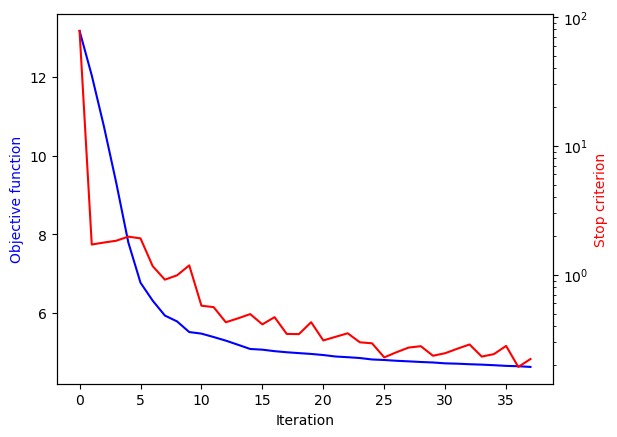

In [18]:
ax1 = plt.plot(res["fun"], color = 'b')   
plt.ylabel('Objective function', color = 'b')
plt.xlabel('Iteration')
ax2 = plt.gca().twinx()
ax2.semilogy(res["stop_criterion"], color = 'r')
plt.ylabel("Stop criterion", color = 'r')
plt.show()

In [19]:
Draw(materials_regions, current["mesh"])

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### 5-c. Constrained optimization with augmented Lagrangian

In [20]:
# Example (constrained optimization)

beta = 0.1
lam = 0
max_outer = 50
max_inner = 10
step = 1e-3

if regularize_symmetry_axis : x = airgap[1:]
else : x = airgap

lam = 0
x_list= [x]
P_list = [obj(x)]
L_list = [cons(x)/scale + L0]

for i in range(max_outer):
    print(f"it {i} : P = {P_list[-1]:.5f} W | L = {L_list[-1]*1000 :.3e} mH | lam = {lam:.3e}")
    lagr = lambda x: lagrangian(x, lam = lam, beta = beta, fun = obj, cons = cons)
    dlagr = lambda x: dx_lagrangian(x, lam = lam, beta = beta, dfun = dObj, dcons = dCons, cons = cons)
    res = gradient_descent(lagr, dlagr, x, step = step, xlb = lbound, xub = ubound, 
                           iter_max = max_inner, precond = True, verbosity = 1)
    x = res["x"][-1]
    x_list.append(x)
    L_list.append(cons(x)/scale + L0)
    P_list.append(obj(x))
    lam += beta * cons(x)
    beta *= 1.1
    
print(f"Final design : P = {P_list[-1]:.5f} W | L = {L_list[-1]*1000 :.3f} mH")
x0 = res["x"][-1]

it 0 : P = 13.16888 W | L = 1.000e+00 mH | lam = 0.000e+00
---- Start gradient descent
it 0 | fun = 1.31689e+01 | step = 1.00e-03
it 1 | fun = 1.20230e+01 | step = 1.20e-03 | crit = 1.71e+00 (accepted ✅)
it 2 | fun = 1.06659e+01 | step = 1.44e-03 | crit = 1.82e+00 (accepted ✅)
it 3 | fun = 9.22036e+00 | step = 1.73e-03 | crit = 1.87e+00 (accepted ✅)
it 4 | fun = 7.71547e+00 | step = 2.07e-03 | crit = 1.90e+00 (accepted ✅)
it 5 | fun = 6.25272e+00 | step = 2.49e-03 | crit = 1.92e+00 (accepted ✅)
it 6 | fun = 5.28692e+00 | step = 2.99e-03 | crit = 1.67e+00 (accepted ✅)
it 8 | fun = 5.05871e+00 | step = 1.79e-03 | crit = 1.13e+00 (accepted ✅)
it 10 | fun = 4.76953e+00 | step = 1.07e-03 | crit = 8.64e-01 (accepted ✅)
---- Stopped after 10 because maximum number of iterations reached.
it 1 : P = 4.76923 W | L = 9.222e-01 mH | lam = -7.785e-03
---- Start gradient descent
it 0 | fun = 4.77017e+00 | step = 1.00e-03
it 1 | fun = 4.55662e+00 | step = 1.20e-03 | crit = 7.27e-01 (accepted ✅)
it 3 

We plot the convergence and optimized design:

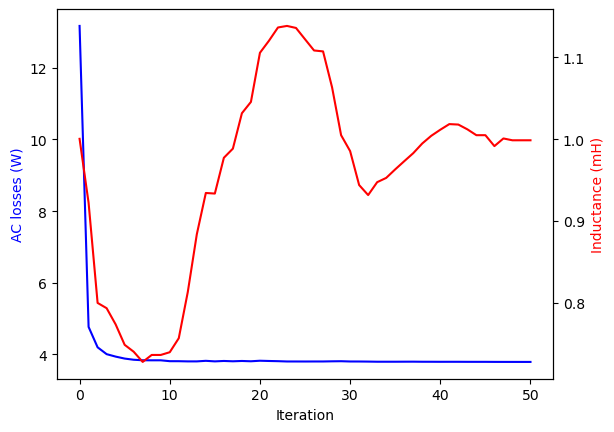

In [21]:
ax1 = plt.plot(P_list, color = 'b')   
plt.ylabel('AC losses (W)', color = 'b')
plt.xlabel('Iteration')
ax2 = plt.gca().twinx()
ax2.plot(np.array(L_list)*1000, color = 'r')
plt.ylabel("Inductance (mH)", color = 'r')
plt.show()

In [22]:
Draw(materials_regions, current["mesh"])

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### 5.d - Scipy version

We probably get a local optima.

In [23]:
from scipy.optimize import minimize, NonlinearConstraint, Bounds

cons_scipy = NonlinearConstraint(cons, lb = -1e-3, ub = 1e-3, jac = dCons)
options = {"maxiter" : 100,
           "ftol" : 1e-3, 
           "disp" : True
          }

bounds = Bounds(lb = lbound, ub = ubound, keep_feasible=True)
results_scipy = minimize(obj, x0, jac=dObj,
                       bounds=bounds,
                       constraints=cons_scipy,
                       options = options, 
                       method="SLSQP")
x_scipy = results_scipy["x"]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.70475043704036
            Iterations: 18
            Function evaluations: 66
            Gradient evaluations: 17


In [26]:
print(f"{results_scipy}")
print(f"Final design (Scipy) : P = {results_scipy["fun"]:.5f} W | L = {(cons(x_scipy)/scale + L0)*1000 :.3f} mH")


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.70475043704036
       x: [ 5.010e-04  1.395e-02 ...  1.395e-02  2.140e-03]
     nit: 18
     jac: [-1.636e+00 -2.834e+00 ... -3.138e+00  7.990e-01]
    nfev: 66
    njev: 17
Final design (Scipy) : P = 3.70475 W | L = 1.002 mH


In [25]:
if regularize_symmetry_axis :x_scipy_bis = [x_scipy[0]] + list(x_scipy)

Draw(materials_regions, gen_meshN(x_scipy_bis)[0] )

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene